# Extracting Velocity Based on Contrast Dispersion in Grafts

 - Extract the graft from the peak intensity image on SimVascular:

        Extract .pth of the manual annotation and .vtu of the mesh

 - Register the CT-MPI sequence if needed.
 - Project the Image values onto the mesh.
 - Convert pathline to vtp and project image onto the pathline.
 - Use a gradient filter and argmax to find the point of shuttle mode on the pathline.
 - Clip the lumen at the point where the shuttle mode causes inconsistency.
 - Take a cross-sectional sample every 5 mm along the lumen.
 - Extract the TAC on every point.
 - Detect the upslope. (?)
 - Interpolate each point.
 - Concatenate upper and lower parts of the lumen at the same time points.
 - Extract temporal and spatial gradient.
 - Extract the velocity.
 - Baysian Framework

In [209]:
import vtk
import glob as glob_module
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.stats import linregress
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
from utilities import *

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

In [2]:
path_ = "/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/3_VesselProjection/VA08B"
graft_name = "LIMA"
vtu_file_ = os.path.join(path_,f"{graft_name}.vtu")
centerline_file_ = os.path.join(path_, f"{graft_name}.pth")
Image_directory_ = "/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B"
Image_names = sorted(glob_module.glob(f"{Image_directory_}/*.vtk"))

In [3]:
Image_names

['/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_01.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_02.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_03.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_04.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_05.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_06.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_07.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_08.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_09.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA08B/VA08B_10.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImage

### Project Images to the Mesh

In [4]:
def ProbeFilter(TargetData, SourceData):
    ProbeFilter=vtk.vtkProbeFilter()
    ProbeFilter.SetInputData(TargetData)
    ProbeFilter.SetSourceData(SourceData)
    ProbeFilter.Update()
    
    return ProbeFilter.GetOutput()

In [5]:
os.path.splitext(os.path.basename(Image_names[0]))[0]

'VA08B_01'

In [6]:
Mesh = ReadVTUFile(vtu_file_)
MeshProjections = {}
for image_name in Image_names:
    Image_ = ReadVTKFile(image_name)
    mesh_projection = ProbeFilter(Mesh, Image_)
    image_root_name = os.path.splitext(os.path.basename(image_name))[0]
    mesh_name = f"{graft_name}_{image_root_name}"
    MeshProjections[image_root_name] = mesh_projection
    WriteVTUFile(os.path.join(path_,f"{mesh_name}.vtu"), mesh_projection)

In [7]:
MeshProjections

{'VA08B_01': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bf05a40) at 0x1a4cbe860>,
 'VA08B_02': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bf04d40) at 0x1a4cbe7a0>,
 'VA08B_03': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966be39b60) at 0x1a4cbeb00>,
 'VA08B_04': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bf0bbf0) at 0x1a4cbe680>,
 'VA08B_05': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bf0ad40) at 0x1a4cbeb60>,
 'VA08B_06': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bccc960) at 0x1a4cbebc0>,
 'VA08B_07': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bf076e0) at 0x1a4cbec20>,
 'VA08B_08': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f9679ffddc0) at 0x1a4cbe500>,
 'VA08B_09': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bf0e820) at 0x1a4cbe800>,
 'VA08B_10': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7f966bbfdc70) at 0x1a4cbec80>,
 'VA08B_11': <vtkmodules.vtkCo

### Read SimVascular Pathline Annotations

In [8]:
with open(centerline_file_, "r") as path:
    #path.readlines()
    tree = ET.parse(path)
root = tree.getroot()

direction_points = []
for direction_point in root.findall(".//path_point/tangent"):
    x = float(direction_point.attrib['x'])
    y = float(direction_point.attrib['y'])
    z = float(direction_point.attrib['z'])
    direction_points.append((x,y,z))

position_points = []
for path_point in root.findall(".//path_point/pos"):
    x = float(path_point.attrib['x'])
    y = float(path_point.attrib['y'])
    z = float(path_point.attrib['z'])
    position_points.append((x,y,z))

path_normals = []
for normal in root.findall(".//path_point/rotation"):
    x = float(normal.attrib['x'])
    y = float(normal.attrib['y'])
    z = float(normal.attrib['z'])
    path_normals.append((x,y,z))

NPoints = len(position_points)
print("the number of points in the centerline is:", NPoints)

binormal = []
for i in range(NPoints):
    binormal_ = np.cross(np.array(direction_points[i]),np.array(path_normals[i]))
    binormal_ /= np.linalg.norm(binormal_)
    binormal.append(binormal_)
    

the number of points in the centerline is: 111


### Convert Pathline to VTP

In [9]:
def points_to_vtp(points):
    # Create VTK points
    vtk_points = vtk.vtkPoints()
    for point in points:
        vtk_points.InsertNextPoint(point)

    # Create a polyline
    polyline = vtk.vtkPolyLine()
    polyline.GetPointIds().SetNumberOfIds(len(points))
    for i in range(len(points)):
        polyline.GetPointIds().SetId(i, i)

    # Create a cell array to store the polyline
    cells = vtk.vtkCellArray()
    cells.InsertNextCell(polyline)

    # Create a polydata object
    polydata = vtk.vtkPolyData()
    polydata.SetPoints(vtk_points)
    polydata.SetLines(cells)

    return polydata

In [10]:
centerline_vtp = points_to_vtp(position_points)
peak_intensity = 5
image_ = ReadVTKFile(Image_names[peak_intensity])

### Search for the Maximum Gradient

In [11]:
def gradient_filter(vtk_image):
    gradient_filter = vtk.vtkImageGradient()
    gradient_filter.SetInputData(vtk_image)
    gradient_filter.SetDimensionality(3)
    gradient_filter.Update()

    return gradient_filter.GetOutput()
    
def define_borders(gradient_image):
    magnitude_filter = vtk.vtkImageMagnitude()
    magnitude_filter.SetInputData(gradient_image)
    magnitude_filter.Update()
    
    return magnitude_filter.GetOutput()

In [12]:
image_gradient_PI = define_borders(gradient_filter(image_))
centerline_vtp_projected = ProbeFilter(centerline_vtp, image_gradient_PI)
WriteVTPFile(os.path.join(path_, f"{graft_name}.vtp"), centerline_vtp_projected)

In [13]:
magnitude_array_name = "Magnitude"
MagnitudeArray = centerline_vtp_projected.GetPointData().GetArray(magnitude_array_name)
ptidx = np.argmax(MagnitudeArray)
Shuttle_mode_point = centerline_vtp_projected.GetPoint(ptidx)

In [14]:
def clip_polydata_with_plane(polydata, origin, normal, inside_out=False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipPolyData()
    clipper.SetInputData(polydata)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

def clip_USGrid_w_plane(USGrid, origin, normal, inside_out = False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(USGrid)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

In [15]:
UpperMesh = {}
LowerMesh = {}

for key, mesh in MeshProjections.items():
    upper_mesh = clip_USGrid_w_plane(mesh, position_points[ptidx], direction_points[ptidx], True)
    mesh_name_upper = f"{graft_name}_{key}_upper"
    UpperMesh[key] = upper_mesh
    WriteVTUFile(os.path.join(path_,f"{mesh_name_upper}.vtu"), upper_mesh)
    
    lower_mesh = clip_USGrid_w_plane(mesh, position_points[ptidx], direction_points[ptidx])
    mesh_name_lower = f"{graft_name}_{key}_lower"
    LowerMesh[key] = lower_mesh
    WriteVTUFile(os.path.join(path_,f"{mesh_name_lower}.vtu"), lower_mesh)


centerline_upper = clip_polydata_with_plane(centerline_vtp_projected, position_points[ptidx], direction_points[ptidx], True)
centerline_lower = clip_polydata_with_plane(centerline_vtp_projected, position_points[ptidx], direction_points[ptidx])

### Cutting the Lumen Every 3 mm

In [16]:
cumulative_distance = [0]
for i in range(1, NPoints):
    dist_ = np.sqrt((position_points[i][0] - position_points[i-1][0])**2 +
                    (position_points[i][1] - position_points[i-1][1])**2 +
                    (position_points[i][2] - position_points[i-1][2])**2 )
    cumulative_distance.append(dist_ + cumulative_distance[i-1])


In [17]:
remainder  = np.array([int(i)%3 for i in cumulative_distance])
indeces = np.where(remainder == 0)
indeces = list(indeces[0])
print(indeces)
indeces_ = [indeces[i] - indeces[i-1] for i in range(1, len(indeces))]
print(indeces_)
indeces_1 = [0]
indeces_1.extend(indeces_)
indeces_1 = indeces_1

indeces_2 = [indeces[i] for i in range(len(indeces_1)) if indeces_1[i] != 1]
print(indeces_2)

[0, 1, 2, 3, 4, 9, 13, 17, 21, 22, 26, 27, 31, 32, 36, 40, 41, 45, 46, 50, 51, 55, 59, 60, 64, 69, 73, 74, 78, 79, 83, 89, 92, 96, 101, 105]
[1, 1, 1, 1, 5, 4, 4, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 5, 4, 1, 4, 1, 4, 6, 3, 4, 5, 4]
[0, 9, 13, 17, 21, 26, 31, 36, 40, 45, 50, 55, 59, 64, 69, 73, 78, 83, 89, 92, 96, 101, 105]


In [176]:
def SequentialCut(PointsArray, interval=3):
    """Finds the location of the cut along the centerline of the lumen.

    Args:
        PointsArray (list): a list of the position of the points along the centerline of the vessel.
        interval (int, optional): To perform the clipping. Distance between the cross sections. Defaults to 3.
    """
    NPoints = len(PointsArray)
    cumulative_distance = [0]
    for i in range(1, NPoints):
        dist_ = np.sqrt((PointsArray[i][0] - PointsArray[i-1][0])**2 +
                        (PointsArray[i][1] - PointsArray[i-1][1])**2 +
                        (PointsArray[i][2] - PointsArray[i-1][2])**2 )
        cumulative_distance.append(dist_ + cumulative_distance[i-1])

    remainder  = np.array([int(i)%interval for i in cumulative_distance])
    indeces = np.where(remainder == 0)
    indeces = list(indeces[0])
    indeces_ = [indeces[i] - indeces[i-1] for i in range(1, len(indeces))]
    indeces_1 = [0]
    indeces_1.extend(indeces_)
    indeces_1 = indeces_1

    indeces_2 = [indeces[i] for i in range(len(indeces_1)) if indeces_1[i] != 1]
    #indeces_2[0] = 2

    return indeces_2    

In [19]:
def slice_w_plane(Volume,Origin,Norm):
    plane=vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice=vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    return Slice.GetOutput()

In [20]:
def SphereClip(volume_image,center,radius):
    sphere = vtk.vtkSphere()
    sphere.SetCenter(center)
    sphere.SetRadius(radius)

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(volume_image)
    clipper.SetClipFunction(sphere)
    clipper.InsideOutOn()
    clipper.GetOutputInformation(1)
    clipper.Update()

    return clipper.GetOutput()

In [21]:
def GetSurfaceArea(polydata):
    properties = vtk.vtkMassProperties()
    properties.AddInputData(polydata)
    properties.Update()
    return properties.GetSurfaceArea()

In [133]:
CrossSections = vtk.vtkAppendPolyData()
Area_ = [] 
for idx in indeces_2:
    cross_section_ = slice_w_plane(MeshProjections['VA08B_06'], position_points[idx+2], direction_points[idx+2])
    area_ = GetSurfaceArea(cross_section_)
    Area_.append(area_)
    radius = np.sqrt(area_/np.pi)
    inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
    CrossSections.AddInputData(ExtractSurface(inner_section_))
CrossSections.Update()
Area = np.mean(np.array(Area_))
WriteVTPFile(os.path.join(path_, "CrossSections.vtp"), CrossSections.GetOutput())

### Extracting cross sections from upper and lower parts of the lumen

#### Detecting which half is leading

In [24]:
ScalarArrayName = image_.GetPointData().GetArrayName(0)
print(ScalarArrayName)

scalars


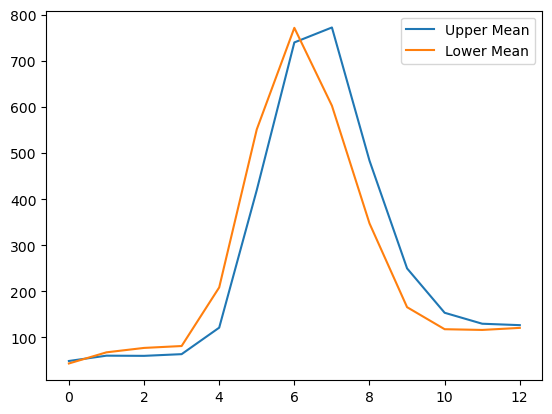

The upper half lags the lower half.


In [38]:
leading = False #if True upper half is leading
upper_mean_ = []
lower_mean_ = []
for name in Image_names:
    Image_ = ReadVTKFile(name)
    centerline_ = ProbeFilter(centerline_vtp, Image_)
    WriteVTPFile(os.path.join(path_, "test_centerline.vtp"), centerline_)
    centerline_upper_ = clip_polydata_with_plane(centerline_, position_points[ptidx], direction_points[ptidx], True)
    WriteVTPFile(os.path.join(path_, "test_centerline_upper.vtp"), centerline_upper_)
    centerline_lower_ = clip_polydata_with_plane(centerline_, position_points[ptidx], direction_points[ptidx])
    WriteVTPFile(os.path.join(path_, "test_centerline_lower.vtp"), centerline_lower_)
    for i in range(Image_.GetPointData().GetNumberOfArrays()):
        arrayname_ = Image_.GetPointData().GetArrayName(i)
        if "scalar" in arrayname_.lower():
            ScalarArrayName = arrayname_
    upper_mean_.append(np.mean(vtk_to_numpy(centerline_upper_.GetPointData().GetArray(ScalarArrayName))))
    lower_mean_.append(np.mean(vtk_to_numpy(centerline_lower_.GetPointData().GetArray(ScalarArrayName))))

count = [i for i in range(len(Image_names))]
plt.figure()
plt.plot(count, upper_mean_, label = "Upper Mean")
plt.plot(count, lower_mean_, label = "Lower Mean")
plt.legend()
plt.show()

max_lower_idx = np.where(np.array(lower_mean_) == max(lower_mean_))
max_upper_idx = np.where(np.array(upper_mean_) == max(upper_mean_))
if max_lower_idx > max_upper_idx:
    leading = True
    print("The upper half leads the lower half.")
else:
    leading = False
    print("The upper half lags the lower half.")



#### Extract the cross sections along the upper part of the lumen

In [64]:
def GetPoints(polydata):
    """Converts the polydata into a list of points.
    """
    NPoints = polydata.GetNumberOfPoints()
    points = []
    for i in range(NPoints):
        points.append(polydata.GetPoint(i))

    return points

todo: 
 - add another loop that loops over the Upper/Lower meshes.
 - create an array of means of each cross section over time.
 - interpolate the array (piecewise interpolation).
 - remove the first and last elements of each array based on upper half leading or lagging.
 - concatenate the arrays.

The following two cells are for test purposes only.

In [ ]:
centerline_upper_points = GetPoints(centerline_upper)
indeces_u = SequentialCut(centerline_upper_points, 2)
CrossSections_u = vtk.vtkAppendPolyData()
for idx in indeces_u:
    cross_section_ = slice_w_plane(UpperMesh[list(UpperMesh.keys())[peak_intensity]], position_points[idx], direction_points[idx])
    radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
    inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
    CrossSections_u.AddInputData(ExtractSurface(inner_section_))
CrossSections_u.Update()
WriteVTPFile(os.path.join(path_, "CrossSections_Upper.vtp"), CrossSections_u.GetOutput())

In [ ]:
centerline_lower_points = GetPoints(centerline_lower)
indeces_l = SequentialCut(centerline_lower_points, 2)
CrossSections_l = vtk.vtkAppendPolyData()
for idx in indeces_l:
    cross_section_ = slice_w_plane(LowerMesh[list(UpperMesh.keys())[peak_intensity]], position_points[len(centerline_upper_points) + idx], direction_points[len(centerline_upper_points) + idx])
    radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
    inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
    CrossSections_l.AddInputData(ExtractSurface(inner_section_))
CrossSections_l.Update()
WriteVTPFile(os.path.join(path_, "CrossSections_Lower.vtp"), CrossSections_l.GetOutput())

#### Looping over all of the meshes and extracting a mean array

In [193]:
centerline_upper_points = GetPoints(centerline_upper)
indeces_u = SequentialCut(centerline_upper_points, 2)

UpperMeanArrays = {}
for idx in indeces_u:
    cross_section_mean_array = []
    for key, mesh in UpperMesh.items():
        cross_section_ = slice_w_plane(mesh, position_points[idx], direction_points[idx])
        radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
        inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
        for i in range(inner_section_.GetPointData().GetNumberOfArrays()):
            arrayname_ = inner_section_.GetPointData().GetArrayName(i)
            if "scalar" in arrayname_.lower():
                ScalarArrayName = arrayname_
        cross_section_mean_array.append(np.mean(vtk_to_numpy(inner_section_.GetPointData().GetArray(ScalarArrayName))))
    
    # add interpolation— then remove the element based on leading/lagging and store it in the dict
    tac = np.empty(2*len(cross_section_mean_array) - 1)
    for i in range(len(cross_section_mean_array) - 1):
        tac[2*i] = cross_section_mean_array[i]
        tac[2*i+1] = (cross_section_mean_array[i] + cross_section_mean_array[i+1])/2
    
    tac[-1] = cross_section_mean_array[-1]

    if leading:
        UpperMeanArrays[cumulative_distance[idx]] = tac
    else:
        UpperMeanArrays[cumulative_distance[idx]] = tac


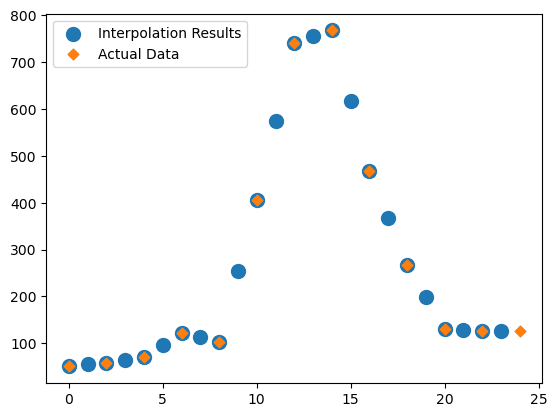

In [145]:
count = [i for i in range(len(tac) - 1)]
plt.figure()
plt.scatter(count, UpperMeanArrays[list(UpperMeanArrays.keys())[-1]],marker = 'o', s = 100, label = "Interpolation Results")
count = [i for i in range(len(tac)) if i%2 == 0]
plt.scatter(count, cross_section_mean_array, marker = 'D', s = 30, label = "Actual Data")
plt.legend(loc= "upper left")
plt.show()

In [194]:
centerline_lower_points = GetPoints(centerline_lower)
indeces_l = SequentialCut(centerline_lower_points, 2)

LowerMeanArrays = {}
for idx in indeces_l:
    cross_section_mean_array = []
    for key, mesh in LowerMesh.items():
        cross_section_ = slice_w_plane(mesh, position_points[len(centerline_upper_points) + idx], direction_points[len(centerline_upper_points) + idx])
        radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
        inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
        for i in range(inner_section_.GetPointData().GetNumberOfArrays()):
            arrayname_ = inner_section_.GetPointData().GetArrayName(i)
            if "scalar" in arrayname_.lower():
                ScalarArrayName = arrayname_
        cross_section_mean_array.append(np.mean(vtk_to_numpy(inner_section_.GetPointData().GetArray(ScalarArrayName))))
    
    # add interpolation— then remove the element based on leading/lagging and store it in the dict
    print(len(cross_section_mean_array))
    tac = np.empty(2*len(cross_section_mean_array) - 1)
    for i in range(len(cross_section_mean_array) - 1):
        tac[2*i] = cross_section_mean_array[i]
        tac[2*i+1] = (cross_section_mean_array[i] + cross_section_mean_array[i+1])/2
    
    tac[-1] = cross_section_mean_array[-1]
    print(len(tac))

    if leading:
        LowerMeanArrays[cumulative_distance[len(centerline_upper_points) + idx]] = tac
    else:
        LowerMeanArrays[cumulative_distance[len(centerline_upper_points) + idx]] = tac

13
25
13
25
13
25
13
25
13
25
13
25


In [115]:
# todo: is there an algorithm that could detect the upslope?

In [195]:
print(len(LowerMesh.keys()))
print(len(LowerMeanArrays[list(LowerMeanArrays.keys())[0]]))
print(len(indeces_u), len(indeces_l))
print(len(UpperMeanArrays), len(LowerMeanArrays))

print(indeces_u)
print(indeces_l)
keys = [cumulative_distance[len(centerline_upper_points) + idx] for idx in indeces_l]
print(keys, len(set(keys)), len(keys))

13
25
29 6
29 6
[0, 7, 10, 13, 15, 18, 21, 25, 28, 31, 34, 37, 40, 43, 47, 50, 53, 56, 59, 62, 65, 69, 72, 75, 78, 81, 84, 89, 91]
[0, 2, 7, 10, 12, 15]
[61.06543110699119, 63.51411616591481, 66.60158323371238, 68.81315891722252, 70.30710058270712, 71.83394892042195] 6 6


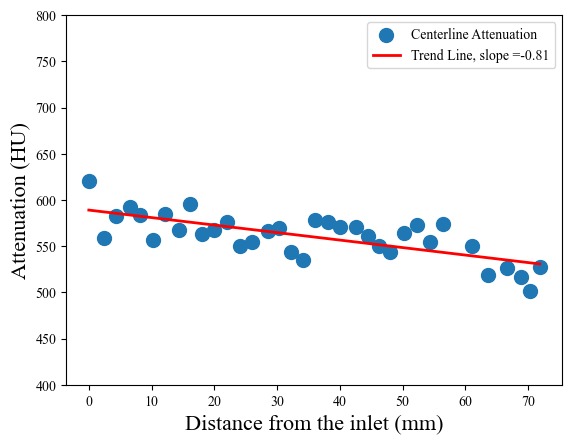

In [215]:
sample_time = 11 # the time point when the spatial attenuation is extracted.

SpatialArray = []
SamplingLocation = list(UpperMeanArrays.keys()) + list(LowerMeanArrays.keys())
for key, array in UpperMeanArrays.items():
    SpatialArray.append(array[sample_time])
for key, array in LowerMeanArrays.items():
    SpatialArray.append(array[sample_time - 1 ])


plt.figure()
plt.scatter(SamplingLocation, SpatialArray, marker = 'o', s = 100, label = "Centerline Attenuation")
x_fit = np.linspace(min(SamplingLocation), max(SamplingLocation), 100).reshape(-1,1)
slope_s, intercept, _, _, _ = linregress(SamplingLocation, SpatialArray)
y_fit = slope_s * x_fit + intercept
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label= f"Trend Line, slope ={int(slope_s*100)/100}")
plt.ylim([400, 800])
plt.xlabel("Distance from the inlet (mm)", size = 16)
plt.ylabel("Attenuation (HU)", size = 16)
plt.legend()
plt.show()

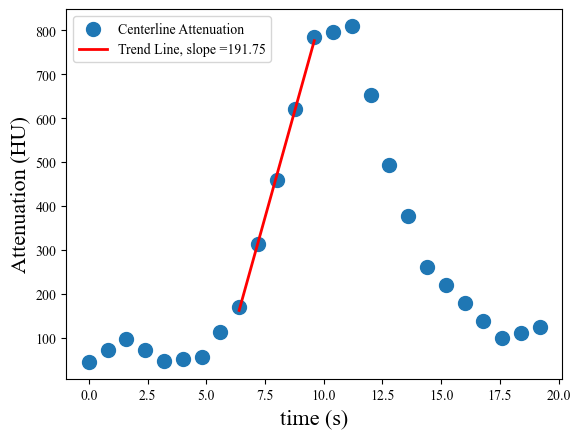

In [219]:
upslope_begins = 8
upslope_ends = 13

heart_rate = 75 #beats per minutes
beat_duration = 60/heart_rate

array = UpperMeanArrays[list(UpperMeanArrays.keys())[0]]

Upslope = array[upslope_begins:upslope_ends]
count = [i * beat_duration for i in range(len(array))]
count_upslope = [i * beat_duration for i in range(upslope_begins, upslope_ends)]

plt.figure()
plt.scatter(count, array, marker = 'o', s = 100, label = "Centerline Attenuation")
x_fit = np.linspace(min(count_upslope), max(count_upslope), 100).reshape(-1,1)
slope_t, intercept, _, _, _ = linregress(count_upslope, Upslope)
y_fit = slope_t * x_fit + intercept
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label= f"Trend Line, slope ={int(slope_t*100)/100}")
plt.xlabel("time (s)", size = 16)
plt.ylabel("Attenuation (HU)", size = 16)
plt.legend(loc = 'upper left')
plt.show()

In [223]:
velocity = abs(slope_t/slope_s)
flow_rate = velocity*Area/1000*60

print(velocity/10, "cm/s")
print(Area, "mm^2")
print(flow_rate, "mL/min")

23.622050996050064 cm/s
2.635059489121798 mm^2
37.34730577779645 mL/min


In [224]:
# todo: Implement the Baysian Framework